In [37]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
class Value:
    def __init__(self, data, _children=(), _op = '', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda : None

    def __repr__(self):
        return f"Value(data = {self.data})"

    def __add__(self, other):
        # this so we can do a + 1. if its not a Value class, then wrap it in value
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        # gradient on addition is just 1
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out

    def __neg__(self):  #-self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def __truediv__(self, other): # self/other
        return self * other**-1

    def __mul__(self, other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        # derivative total is just local derivative * global derivative
        # the += mark for multivariable case, we accumulate the gradient for each node
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*self.data**(other-1) * out.grad

        out._backward = _backward

        return out

    # if we cant do ex, 2.__mul__(a) ==> a.__mul__(2)
    # basily do swapping order of the operator
    def __rmul__(self, other):
        return self * other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1) / (math.exp(2*x) +1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sorting : kindda like DFS sorting -> go to the bottom of the leaf, then change brance
        # its used so we can automaticly search for the backward propagation
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [39]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [40]:
a = Value(2.0)
b = Value(4.0)

a-b

Value(data=-2.0)

In [41]:
from graphviz import Digraph

# tracing all the nodes and edges from the calculation
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # Lr = left to right
    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # creating the rectangular node
        dot.node(name=uid, label= "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
        if n._op:
            # creating the circle operation node
            dot.node(name=uid + n._op, label= n._op)
            dot.edge(uid+n._op, uid)
    # creatiing edges
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [42]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

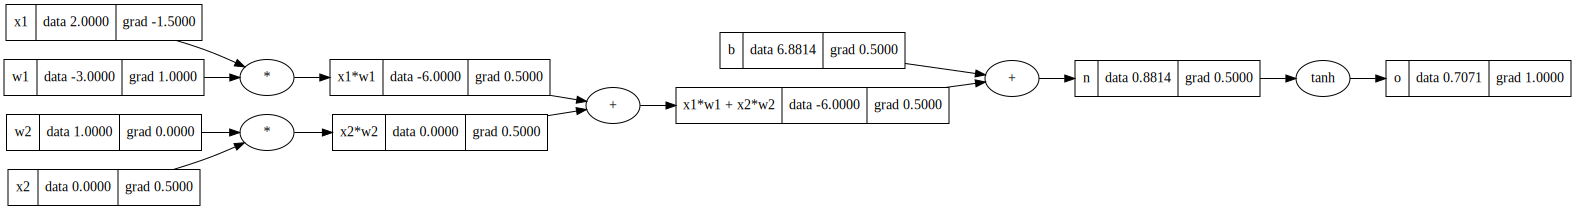

In [43]:
draw_dot(o)

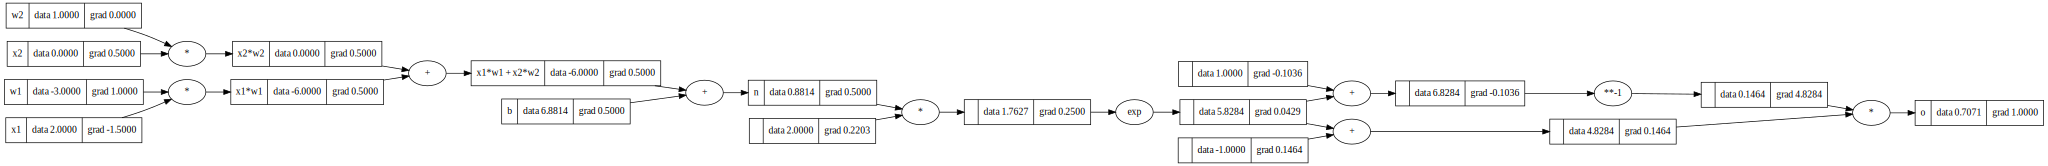

In [44]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1) / (e + 1)

o.label = 'o'
o.backward()
draw_dot(o)

## Implementation in Pytorch

In [45]:
import torch


x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [46]:
import random

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]



In [47]:
x = [2.0, 3.0, -1.0]
n = MLP(3,[4,4,1])
n(x)

Value(data=-0.8174316239141786)

In [48]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [49]:
ypred = [n(x) for x in xs]
ypred

[Value(data=-0.8174316239141786),
 Value(data=-0.9146105281800158),
 Value(data=-0.8837750499756456),
 Value(data=-0.8683649594493887)]

In [50]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.814644930207503)

In [51]:
loss.backward()

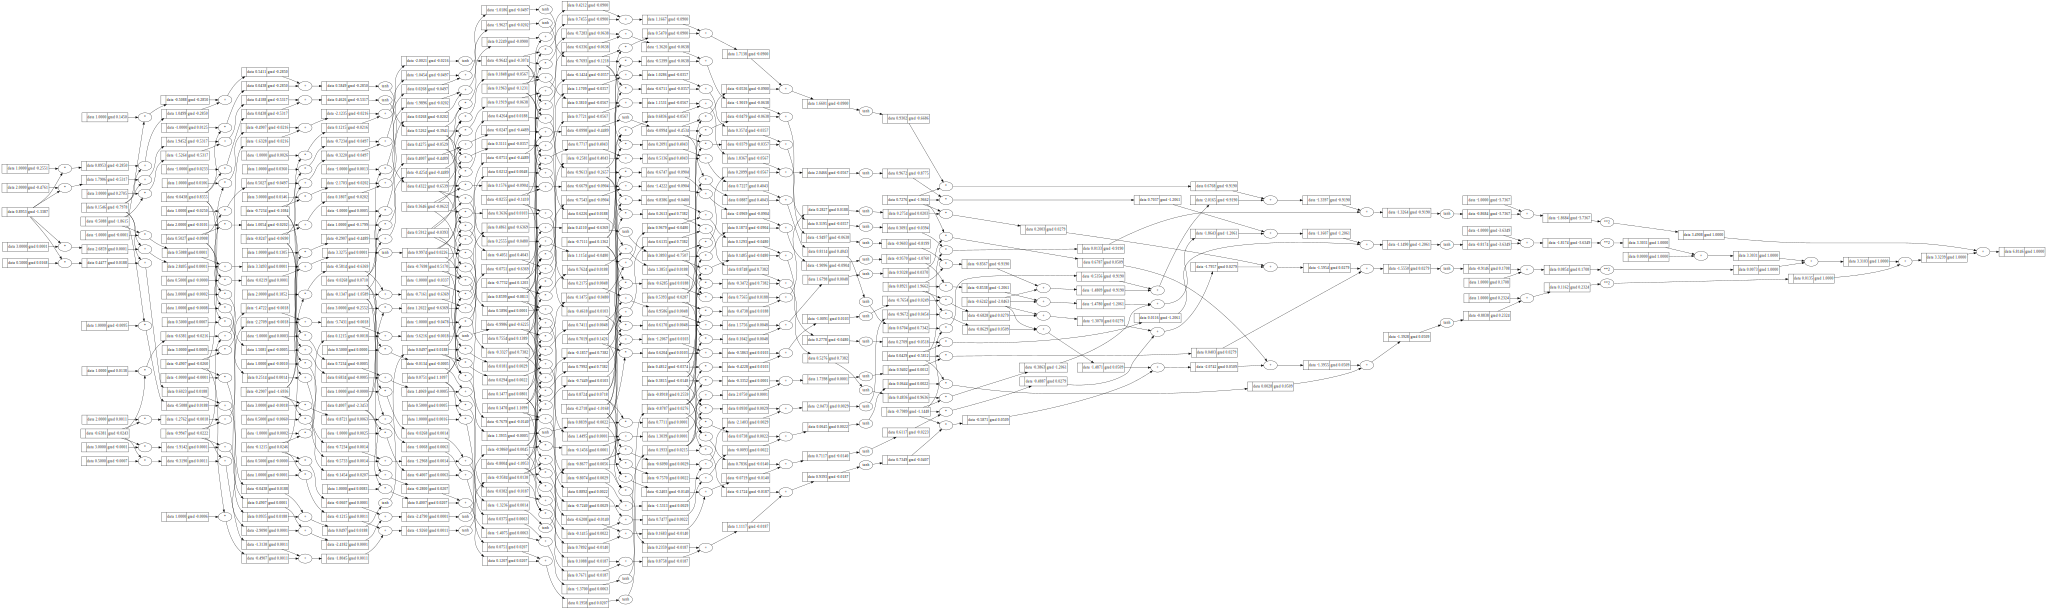

In [52]:
draw_dot(loss)

In [53]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 6.814644930207503
1 1.9208223431752538
2 1.5236236395880935
3 3.1492245927289413
4 3.791929338469479
5 0.08179973245794678
6 0.05717158648068117
7 0.046072475532030505
8 0.03914171840470676
9 0.03420388053961348
10 0.030431766899899494
11 0.027424882229366086
12 0.02495818024283304
13 0.022891972464652695
14 0.021133297383075567
15 0.019617075583651403
16 0.018295976640860693
17 0.01713454377018196
18 0.016105578829423768
19 0.015187809998662356
